/tmp/ipython-input-1550078341.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['account.Charges.Monthly'].fillna(df['account.Charges.Monthly'].median(), inplace=True)
/tmp/ipython-input-1550078341.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing '

Shape do DataFrame: (7267, 22)

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   obj

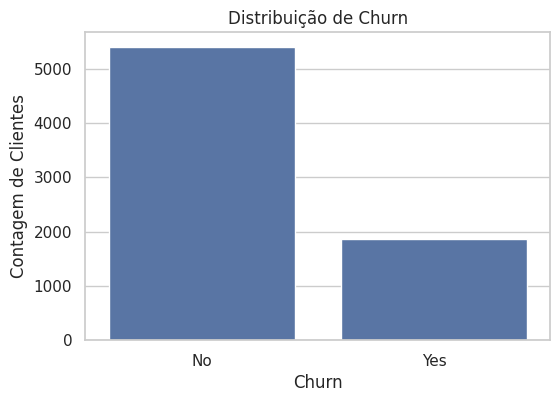

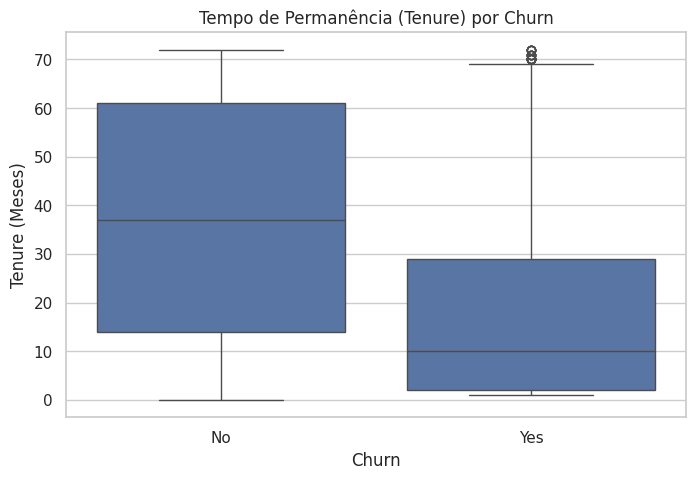

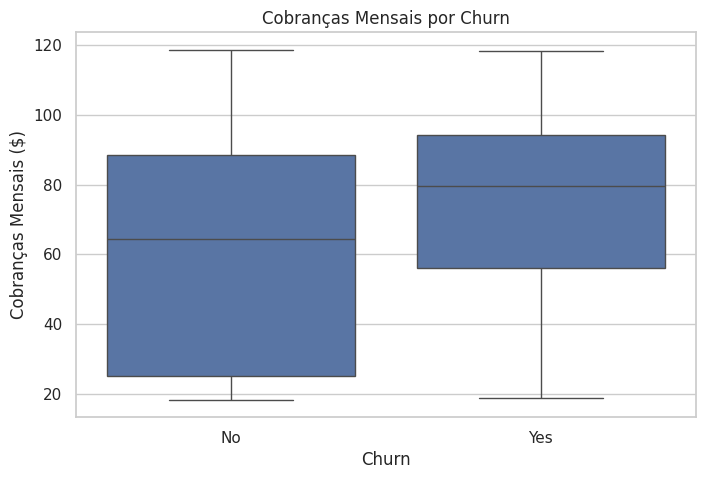

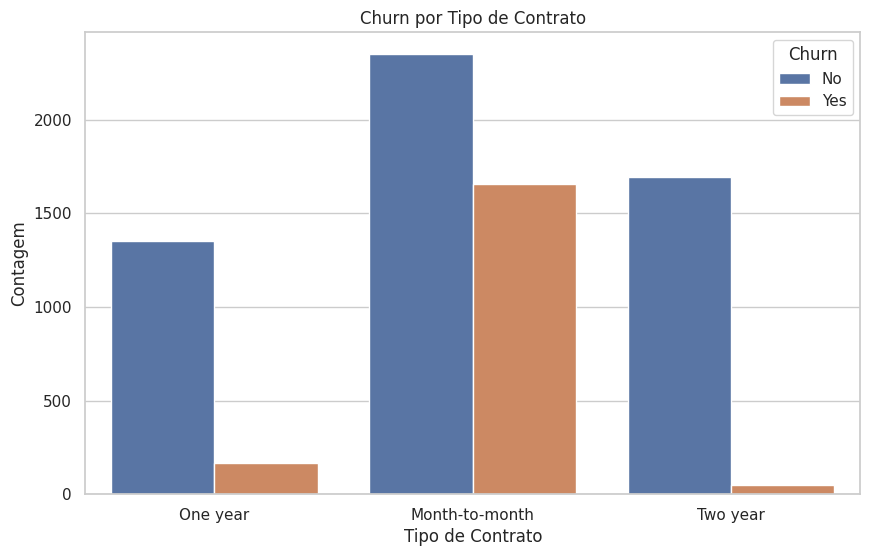

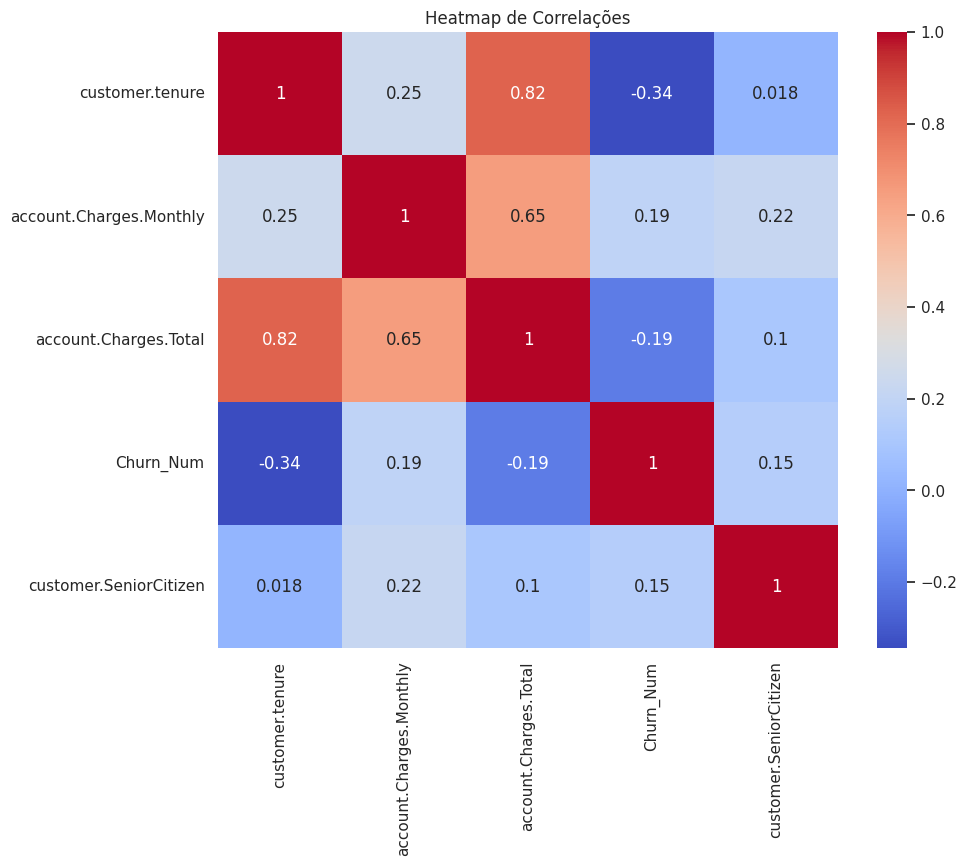


Dados tratados salvos em 'telecom_churn_cleaned.csv'.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json  # Se precisar carregar como string; caso contrário, use pd.read_json

# Passo 1: ETL - Extração e Carregamento
# Carregar o JSON e achatar a estrutura aninhada
df = pd.read_json('TelecomX_Data.json')
df = pd.json_normalize(df.to_dict(orient='records'))

# Passo 2: Transformação (Limpeza dos Dados)
# Converter colunas de cobranças para numérico (float)
df['account.Charges.Monthly'] = pd.to_numeric(df['account.Charges.Monthly'], errors='coerce')
df['account.Charges.Total'] = pd.to_numeric(df['account.Charges.Total'], errors='coerce')

# Tratar valores vazios em 'Churn' (ex.: substituir '' por 'No' ou remover; aqui substituo por 'No' para preservar dados)
df['Churn'] = df['Churn'].replace('', 'No')

# Mapear 'Churn' para numérico (0: No, 1: Yes) para análises quantitativas
df['Churn_Num'] = df['Churn'].map({'No': 0, 'Yes': 1})

# Tratar possíveis missing values (preencher com mediana para numéricos, modo para categóricos)
df['account.Charges.Monthly'].fillna(df['account.Charges.Monthly'].median(), inplace=True)
df['account.Charges.Total'].fillna(df['account.Charges.Total'].median(), inplace=True)

# Verificar e remover duplicatas se existirem
df.drop_duplicates(subset=['customerID'], inplace=True)

# Informações gerais após limpeza
print("Shape do DataFrame:", df.shape)
print("\nInformações do DataFrame:")
print(df.info())
print("\nValores missing restantes:")
print(df.isnull().sum())

# Passo 3: EDA - Análise Exploratória
# Estatísticas descritivas
print("\nEstatísticas Descritivas:")
print(df[['customer.tenure', 'account.Charges.Monthly', 'account.Charges.Total']].describe())

# Taxa de Churn geral
churn_rate = df['Churn_Num'].mean() * 100
print(f"\nTaxa de Churn Geral: {churn_rate:.2f}%")

# Churn por variáveis categóricas (exemplos)
print("\nChurn por Tipo de Contrato:")
print(pd.crosstab(df['account.Contract'], df['Churn'], normalize='index') * 100)  # % por linha

print("\nChurn por Serviço de Internet:")
print(pd.crosstab(df['internet.InternetService'], df['Churn'], normalize='index') * 100)

print("\nChurn por Método de Pagamento:")
print(pd.crosstab(df['account.PaymentMethod'], df['Churn'], normalize='index') * 100)

# Correlações (apenas numéricas)
corr = df[['customer.tenure', 'account.Charges.Monthly', 'account.Charges.Total', 'Churn_Num', 'customer.SeniorCitizen']].corr()
print("\nMatriz de Correlações:")
print(corr)

# Passo 4: Visualizações Estratégicas
# Configurar estilo
sns.set(style="whitegrid")

# Visualização 1: Distribuição de Churn
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Distribuição de Churn')
plt.xlabel('Churn')
plt.ylabel('Contagem de Clientes')
plt.show()

# Visualização 2: Tenure vs Churn (Boxplot para identificar padrões)
plt.figure(figsize=(8, 5))
sns.boxplot(x='Churn', y='customer.tenure', data=df)
plt.title('Tempo de Permanência (Tenure) por Churn')
plt.xlabel('Churn')
plt.ylabel('Tenure (Meses)')
plt.show()

# Visualização 3: Cobranças Mensais vs Churn
plt.figure(figsize=(8, 5))
sns.boxplot(x='Churn', y='account.Charges.Monthly', data=df)
plt.title('Cobranças Mensais por Churn')
plt.xlabel('Churn')
plt.ylabel('Cobranças Mensais ($)')
plt.show()

# Visualização 4: Churn por Tipo de Contrato (Barplot)
plt.figure(figsize=(10, 6))
sns.countplot(x='account.Contract', hue='Churn', data=df)
plt.title('Churn por Tipo de Contrato')
plt.xlabel('Tipo de Contrato')
plt.ylabel('Contagem')
plt.show()

# Visualização 5: Heatmap de Correlações
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Heatmap de Correlações')
plt.show()

# Passo 5: Salvar o DataFrame tratado (opcional, para uso futuro)
df.to_csv('telecom_churn_cleaned.csv', index=False)
print("\nDados tratados salvos em 'telecom_churn_cleaned.csv'.")